# Twitter Covid-19 Analysis
Tweets are collected with Twitter API and saved on the project GitHub repository.

In [ ]:
import seaborn as sns
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 11.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=587318f31ee6e6473aec7dcd66b11f770698e7923ab0d7f896340adf8ed1d2e7
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
from langdetect import detect

In [ ]:
# Run this code for the first time, to install the libraries and download wordnet
# %reset
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
!{sys.executable} -m pip install pyLDAvis
!{sys.executable} -m pip install gensim
nltk.download('stopwords')
nltk.download('wordnet')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 1.6MB 9.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=a9c96beb4badb4f34a55266bd2a0755c30ed4a245bac19a8a3924a5972ba5e52
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Load

## Tweets
Loading the tweets collected with Twitter API

In [ ]:
# load tweets
url = 'https://raw.githubusercontent.com/jaeh-lee/twitter_covid19/master/tweets.csv'
df = pd.read_csv(url)

In [ ]:
# number of tweets
len(df)

146576

In [ ]:
# save date only
created_date = pd.to_datetime(df['created_at'])
df['created_date'] = created_date.dt.date
count_created_date = df.groupby('created_date').size().reset_index().rename(columns={0: 'count'})

Text(0, 0.5, 'Number of Tweets')

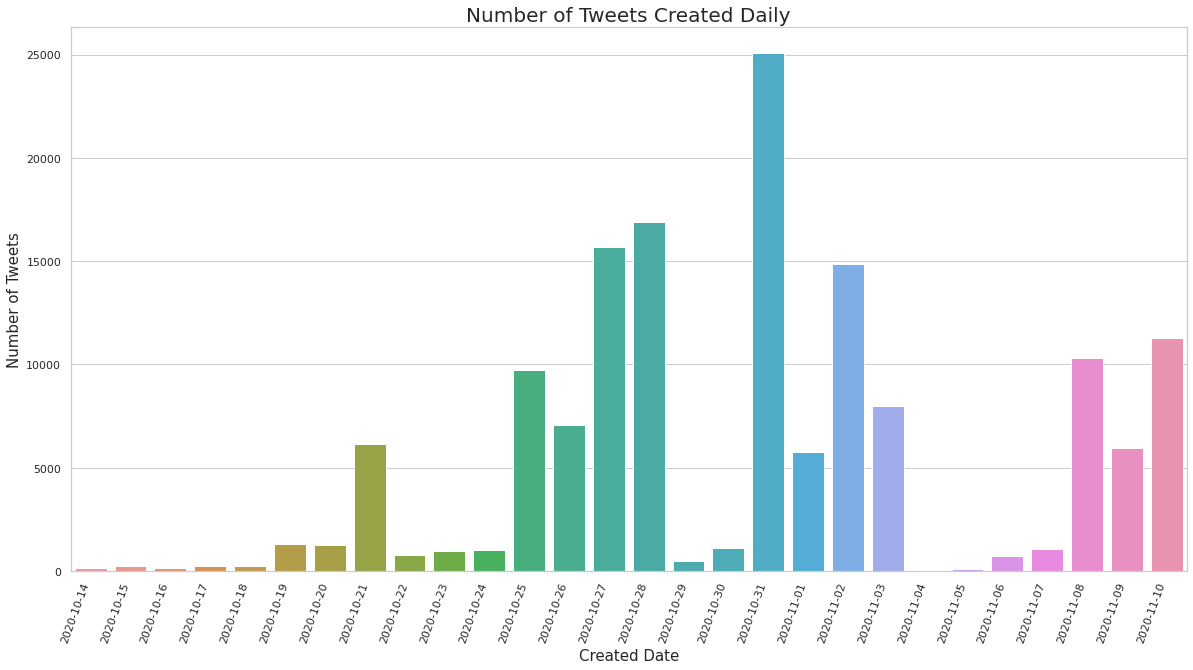

In [ ]:
# number of tweeets
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,10))
plt.xticks(rotation=70, ha="right")
ax = sns.barplot(x="created_date", y="count", data=count_created_date)
ax.axes.set_title("Number of Tweets Created Daily", fontsize=20)
ax.set_xlabel("Created Date",fontsize=15)
ax.set_ylabel("Number of Tweets",fontsize=15)

### COVID-19 Global Cases
Loading data from a GitHub repository of Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) during the period which the tweets are collected.

In [ ]:
# Daily reports for October (1-10)
csse_10 = pd.DataFrame()
for i in range(13, 32):
  report_date = '10-{}-2020'.format(str(i).zfill(2))
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'.format(report_date)
  df = pd.read_csv(url)
  df['Report_Date'] = report_date
  csse_10 = pd.concat([csse_10, df], ignore_index=True)

# Daily reports for November (1-10)
csse_11 = pd.DataFrame()
for i in range(1, 11):
  report_date = '11-{}-2020'.format(str(i).zfill(2))
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'.format(report_date)
  df = pd.read_csv(url)
  df['Report_Date'] = report_date
  csse_11 = pd.concat([csse_11, df], ignore_index=True)

# Combine two dataframes
csse = pd.concat([csse_10, csse_11], ignore_index=True)
csse.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Report_Date,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-10-14 04:24:05,33.93911,67.709953,39928,1480.0,33308,5140.0,Afghanistan,102.567947,3.706672,10-13-2020,NaN,NaN
1,NaN,NaN,NaN,Albania,2020-10-14 04:24:05,41.15330,20.168300,15752,429.0,9675,5648.0,Albania,547.362569,2.723464,10-13-2020,NaN,NaN
2,NaN,NaN,NaN,Algeria,2020-10-14 04:24:05,28.03390,1.659600,53399,1818.0,37492,14089.0,Algeria,121.773614,3.404558,10-13-2020,NaN,NaN
3,NaN,NaN,NaN,Andorra,2020-10-14 04:24:05,42.50630,1.521800,2995,57.0,1928,1010.0,Andorra,3876.269980,1.903172,10-13-2020,NaN,NaN
4,NaN,NaN,NaN,Angola,2020-10-14 04:24:05,-11.20270,17.873900,6680,222.0,2761,3697.0,Angola,20.324790,3.323353,10-13-2020,NaN,NaN


In [ ]:
# Filter US only
csse_us = csse[csse['Country_Region'] == 'US']
csse_us_clean = csse_us.groupby('Report_Date')['Confirmed', 'Deaths'].sum().reset_index()

# Calculate and add 'New_Cases'
csse_us_clean['New_Cases'] = csse_us_clean['Confirmed'].diff()
csse_us_clean['New_Deaths'] = csse_us_clean['Deaths'].diff()
csse_us_clean = csse_us_clean.drop([0,0]).reset_index(drop=True)
csse_us_clean.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Report_Date,Confirmed,Deaths,New_Cases,New_Deaths
0,10-14-2020,7919464,217059.0,58830.0,985.0
1,10-15-2020,7983919,217882.0,64455.0,823.0
2,10-16-2020,8052283,218774.0,68364.0,892.0
3,10-17-2020,8109476,219489.0,57193.0,715.0
4,10-18-2020,8159046,219879.0,49570.0,390.0


In [ ]:
csse_us_clean = pd.read_csv('csse_us_clean.csv')

## Exploratory Visualizations

### Number of Daily Tweets vs. New Cases
I’m comparing the number of tweets and the number of new cases created daily. The bars represent the number of tweets, and the line represents the number of new cases. The trend seems to be that each time we observe a record high daily count of new cases, there’s an explosive spike in the number of tweets the following day. For example, on October 24th we hit a local maximum, and the next day on 25th we can see almost 10 times more tweets than the past day. This trend is also spotted on October 30th and 31st, and November 7th and 8th.

[Text(0, 0, '10-14-2020'),
 Text(0, 0, '10-15-2020'),
 Text(0, 0, '10-16-2020'),
 Text(0, 0, '10-17-2020'),
 Text(0, 0, '10-18-2020'),
 Text(0, 0, '10-19-2020'),
 Text(0, 0, '10-20-2020'),
 Text(0, 0, '10-21-2020'),
 Text(0, 0, '10-22-2020'),
 Text(0, 0, '10-23-2020'),
 Text(0, 0, '10-24-2020'),
 Text(0, 0, '10-25-2020'),
 Text(0, 0, '10-26-2020'),
 Text(0, 0, '10-27-2020'),
 Text(0, 0, '10-28-2020'),
 Text(0, 0, '10-29-2020'),
 Text(0, 0, '10-30-2020'),
 Text(0, 0, '10-31-2020'),
 Text(0, 0, '11-01-2020'),
 Text(0, 0, '11-02-2020'),
 Text(0, 0, '11-03-2020'),
 Text(0, 0, '11-04-2020'),
 Text(0, 0, '11-05-2020'),
 Text(0, 0, '11-06-2020'),
 Text(0, 0, '11-07-2020'),
 Text(0, 0, '11-08-2020'),
 Text(0, 0, '11-09-2020'),
 Text(0, 0, '11-10-2020')]

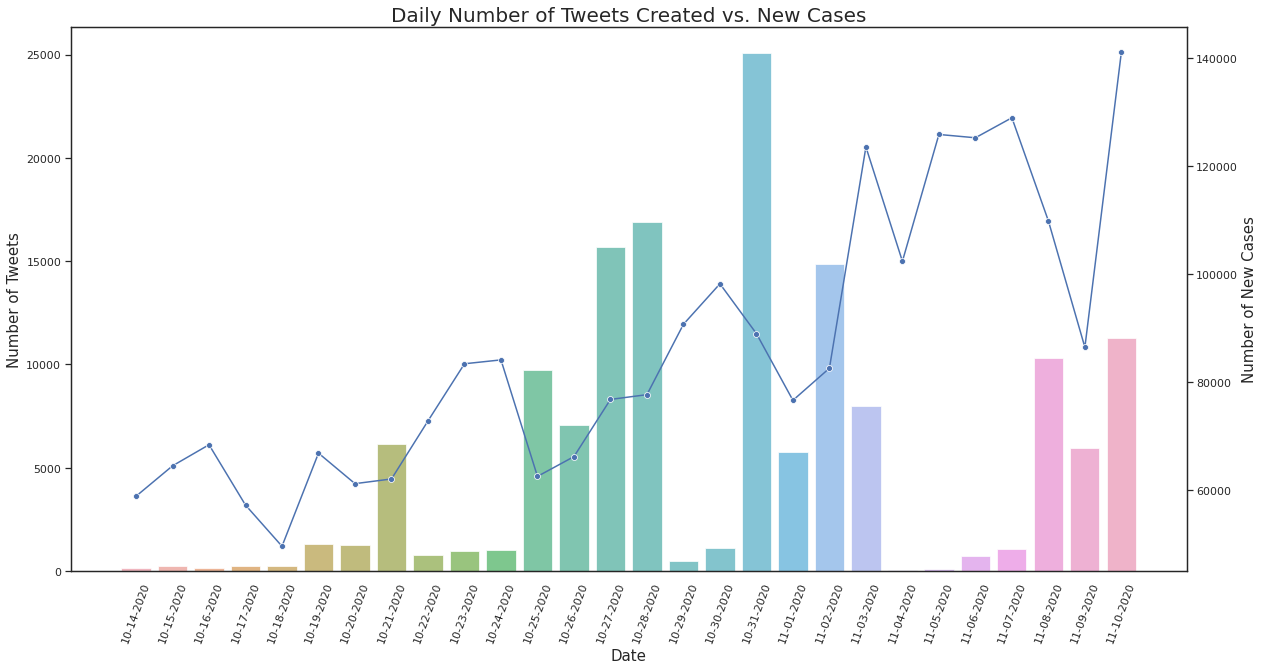

In [ ]:
# number of tweeets vs. new cases
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()

bar = sns.barplot(x="created_date", y="count", data=count_created_date, ax=ax, alpha=0.7)
line = sns.lineplot(data=csse_us_clean, x='Report_Date', y='New_Cases', ax=ax2, marker='o')

ax.axes.set_title("Daily Number of Tweets Created vs. New Cases", fontsize=20)
ax.set_xlabel("Date",fontsize=15)
ax.set_ylabel("Number of Tweets",fontsize=15)
ax2.set_ylabel("Number of New Cases", fontsize=15)

bar.set_xticklabels(csse_us_clean['Report_Date'], rotation=70)

### Number of Daily Tweets vs. New Deaths

[Text(0, 0, '10-14-2020'),
 Text(0, 0, '10-15-2020'),
 Text(0, 0, '10-16-2020'),
 Text(0, 0, '10-17-2020'),
 Text(0, 0, '10-18-2020'),
 Text(0, 0, '10-19-2020'),
 Text(0, 0, '10-20-2020'),
 Text(0, 0, '10-21-2020'),
 Text(0, 0, '10-22-2020'),
 Text(0, 0, '10-23-2020'),
 Text(0, 0, '10-24-2020'),
 Text(0, 0, '10-25-2020'),
 Text(0, 0, '10-26-2020'),
 Text(0, 0, '10-27-2020'),
 Text(0, 0, '10-28-2020'),
 Text(0, 0, '10-29-2020'),
 Text(0, 0, '10-30-2020'),
 Text(0, 0, '10-31-2020'),
 Text(0, 0, '11-01-2020'),
 Text(0, 0, '11-02-2020'),
 Text(0, 0, '11-03-2020'),
 Text(0, 0, '11-04-2020'),
 Text(0, 0, '11-05-2020'),
 Text(0, 0, '11-06-2020'),
 Text(0, 0, '11-07-2020'),
 Text(0, 0, '11-08-2020'),
 Text(0, 0, '11-09-2020'),
 Text(0, 0, '11-10-2020')]

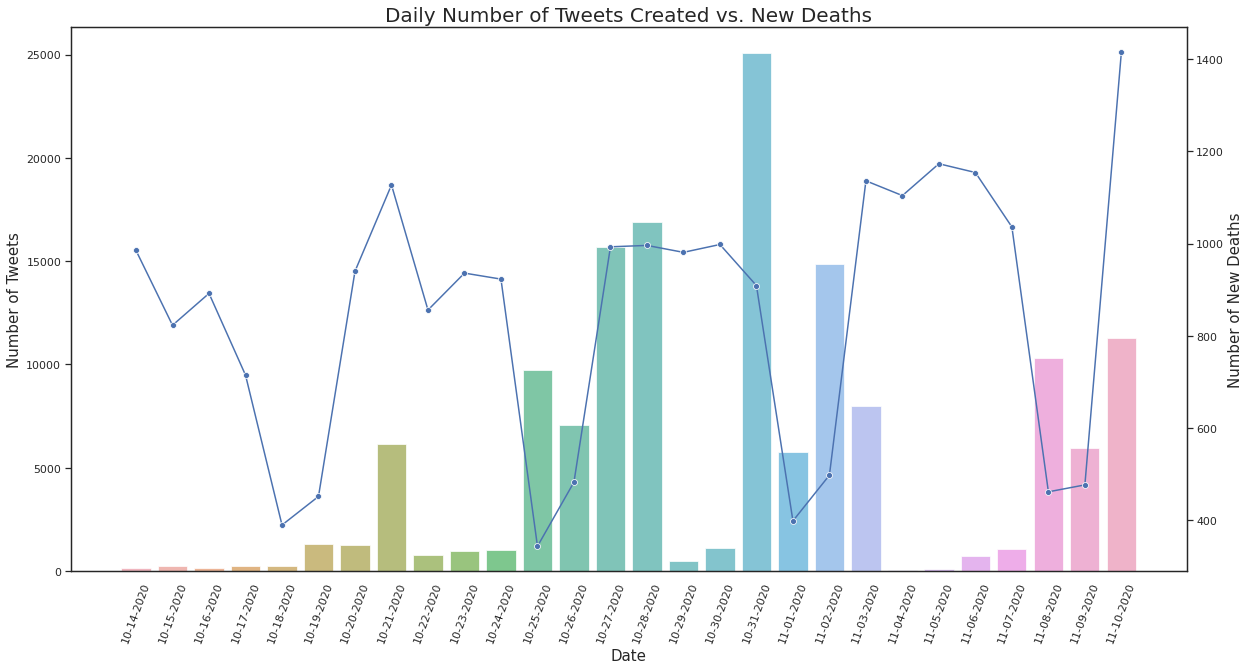

In [ ]:
# number of tweeets vs. new cases
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()

bar = sns.barplot(x="created_date", y="count", data=count_created_date, ax=ax, alpha=0.7)
line = sns.lineplot(data=csse_us_clean, x='Report_Date', y='New_Deaths', ax=ax2, marker='o')

ax.axes.set_title("Daily Number of Tweets Created vs. New Deaths", fontsize=20)
ax.set_xlabel("Date",fontsize=15)
ax.set_ylabel("Number of Tweets",fontsize=15)
ax2.set_ylabel("Number of New Deaths", fontsize=15)

bar.set_xticklabels(csse_us_clean['Report_Date'], rotation=70)

### Correlations

In [ ]:
csse_us_clean['Tweet_Counts'] = count_created_date['count']

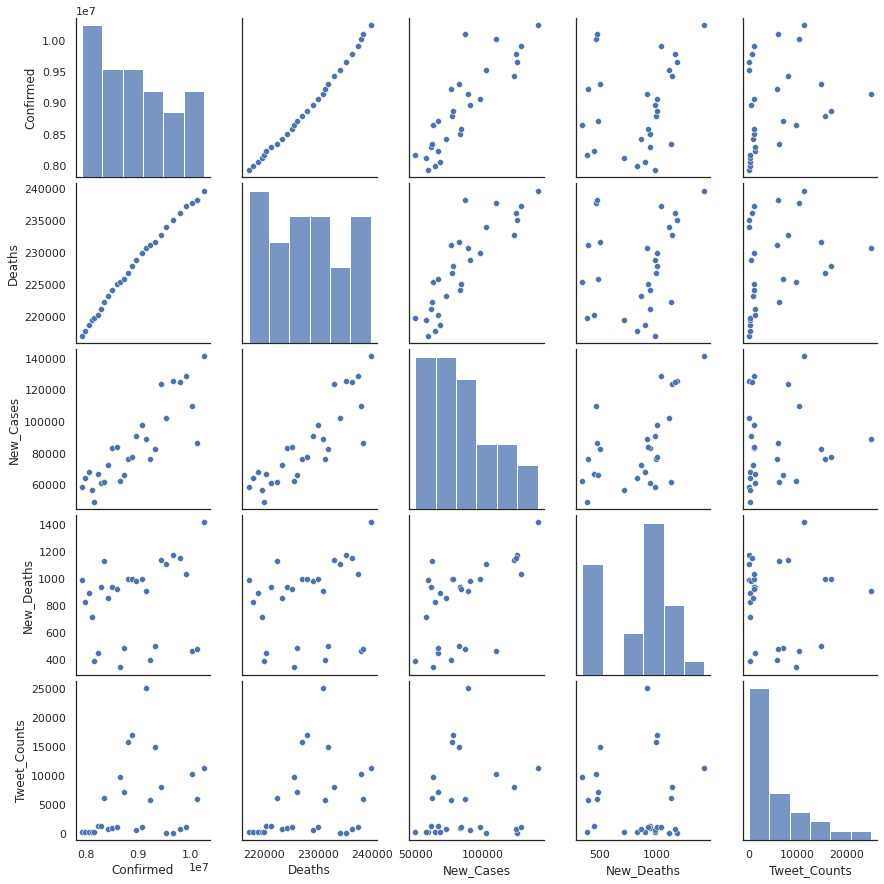

In [ ]:
sns.pairplot(csse_us_clean)

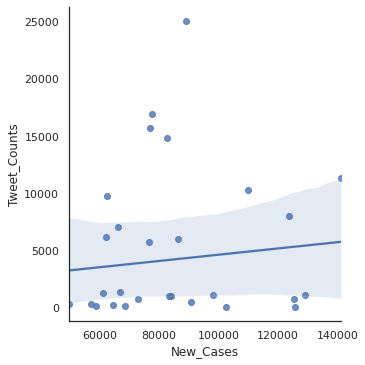

In [ ]:
# a slightly negative correlation between daily number of tweets and new cases
sns.lmplot(data=csse_us_clean, x='New_Cases', y='Tweet_Counts', robust=True)

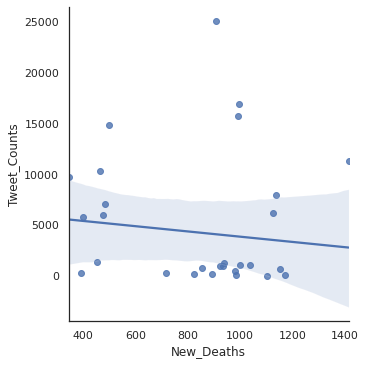

In [ ]:
# a slightly negative correlation between daily number of tweets and new deaths
sns.lmplot(data=csse_us_clean, x='New_Deaths', y='Tweet_Counts', robust=True)

### Top Hashtags

Text(0, 0.5, 'Hashtags')

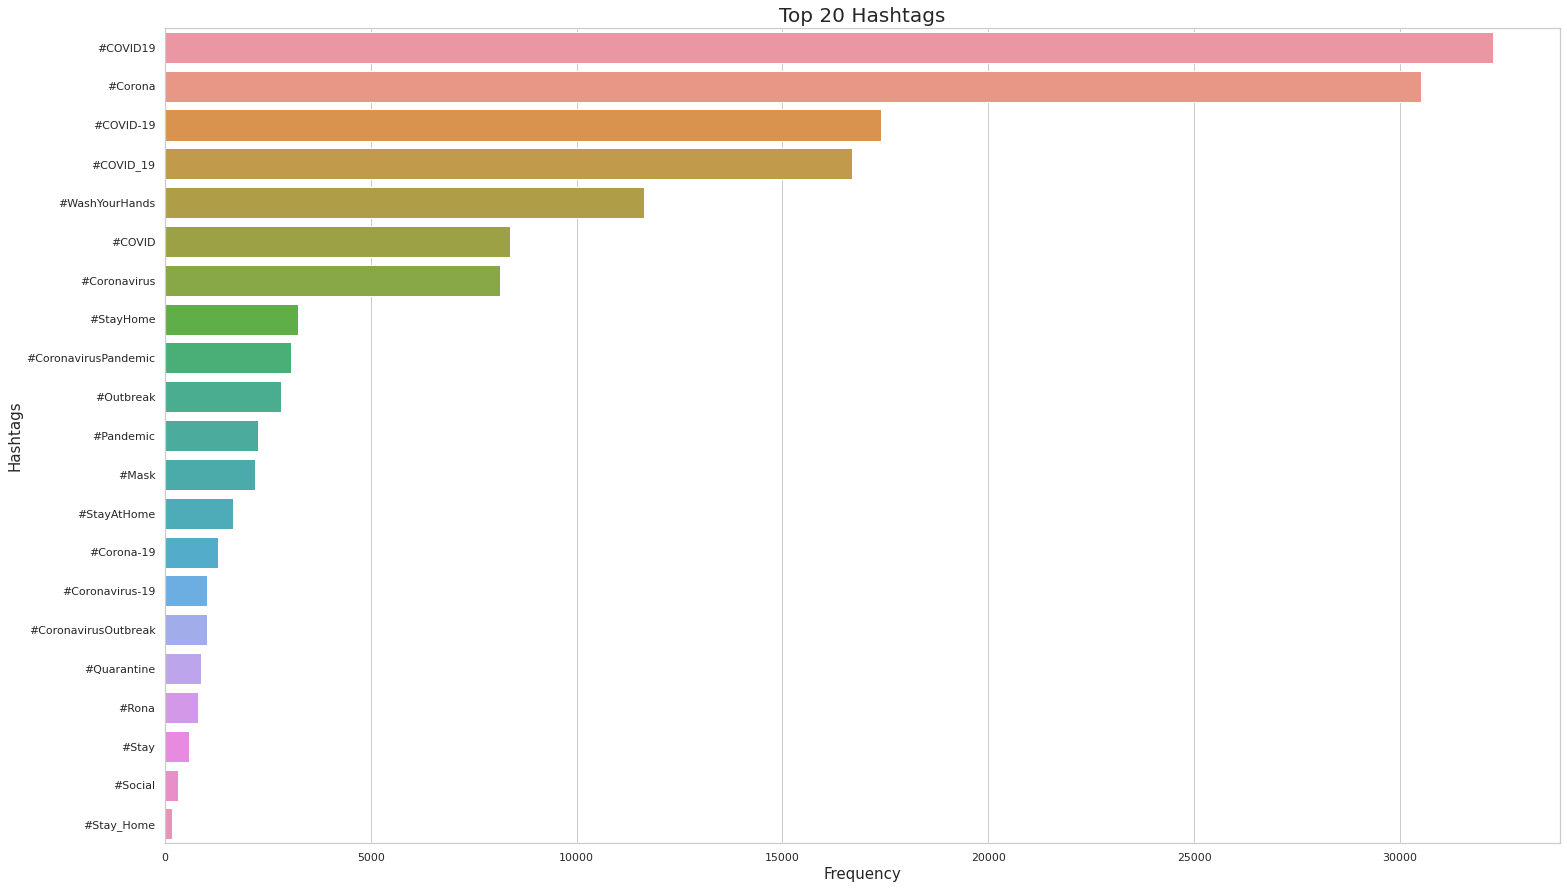

In [ ]:
# top hashtags
freq_terms = df.groupby('term').size().sort_values(ascending=False).reset_index()
freq_terms = freq_terms.rename(columns={0: 'count'})

# barplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(25,15))
ax = sns.barplot(y="term", x="count", data=freq_terms.iloc[:21])
ax.axes.set_title("Top 20 Hashtags", fontsize=20)
ax.set_xlabel("Frequency",fontsize=15)
ax.set_ylabel("Hashtags",fontsize=15)

## Topic Modeling

### Filter English Tweets

In [ ]:
# determine what language the tweet text is in
language = []
n = len(df)
for i in range(n):
  try:
    lang = detect(df.iloc[i].text)
  except:
    lang = np.nan
  language.append(lang)

In [ ]:
df['language'] = language

In [ ]:
csse_us_clean.to_csv('csse_us_clean.csv')
df.to_csv('tweets_final.csv')

In [ ]:
# df_foreign = df[((df['sentiment_compound']==0) & (df['sentiment_pos']==0) & (df['sentiment_neg']==0))]
# df_eng = df[~((df['sentiment_compound']==0) & (df['sentiment_pos']==0) & (df['sentiment_neg']==0))]
# print('Number of tweets in English: {}'.format(len(df_eng)))
# print('Number of tweets in foreign languages: {}'.format(len(df_foreign)))

Number of tweets in English: 46679
Number of tweets in foreign languages: 37289


In [ ]:
# for resuming the anlaysis without having to preprocess the original dataset 
# df = pd.read_csv('tweets_final.csv')

In [ ]:
# filter tweets in English
df_eng = df[df['language'] == 'en']

In [ ]:
# the two "spikes" from sentiment analysis
df_21 = df_eng[df_eng['created_date']=='2020-10-21']
df_28 = df_eng[df_eng['created_date']=='2020-10-28']

### Preprocess and Train with Gensim

In [ ]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))

In [ ]:
text_data = []
for text in df['text']:
    tokens = prepare_text_for_lda(text)
    text_data.append(tokens)

In [ ]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus

In [ ]:
import gensim

NUM_TOPICS = [3, 5, 10]
# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.043*"SCREEN_NAME" + 0.018*"washyourhands" + 0.015*"stayhome" + 0.012*"wearamask" + 0.012*"covid19"'),
 (1,
  '0.056*"corona" + 0.039*"SCREEN_NAME" + 0.008*"nicht" + 0.006*"lockdown" + 0.004*"haben"'),
 (2,
  '0.087*"SCREEN_NAME" + 0.039*"covid19" + 0.037*"covid-19" + 0.023*"coronavirus" + 0.021*"case"'),
 (3,
  '0.078*"SCREEN_NAME" + 0.018*"covid_19" + 0.017*"covid-19" + 0.016*"covid19" + 0.010*"casos"'),
 (4,
  '0.156*"SCREEN_NAME" + 0.037*"covid_19" + 0.015*"covid19" + 0.005*"covid" + 0.004*"france"')]

In [ ]:
def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.050*"SCREEN_NAME" + 0.045*"corona" + 0.006*"nicht" + 0.006*"covid19" + 0.005*"covid_19"'),
 (1,
  '0.079*"SCREEN_NAME" + 0.026*"covid_19" + 0.016*"covid19" + 0.014*"covid-19" + 0.009*"coronavirus"'),
 (2,
  '0.093*"SCREEN_NAME" + 0.028*"covid19" + 0.022*"covid-19" + 0.012*"case" + 0.012*"coronavirus"')]

### LDA Map
Each circle is a group of similar tweets based on their word choice. The size of the circles represent how many tweets are included in that topic, and the distance between the circles represent how similar those topics are to each other. In other words, the closer the two circles are with each other, the more similar the topics are to each other.

In Topic 1, highlighted in red on the left, we could observe that these tweets are concerned with health issues and safety measures. The top 3 tokens are: “wash your hands”, “stay home” and “wear a mask”, followed by “please”. The list continues to include “social distancing”, “quarantine”, “protect”, “family”, and “mental”, suggesting that people are not only concerned with their physical but also mental health, as the pandemic continues to surge globally.

Topic 3, on the other hand, is associated more directly with the COVID-19, and its record high, rapidly rising cases and the latest news on vaccines. Some of the top terms are “vaccine”, “death”, “pfizer”, and “record”, “breaking”, “million”.


In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

[(0,
  '0.046*"SCREEN_NAME" + 0.040*"casos" + 0.037*"covid-19" + 0.019*"salud" + 0.016*"covid19"'),
 (1,
  '0.124*"SCREEN_NAME" + 0.035*"covid-19" + 0.026*"covid19" + 0.016*"pandemic" + 0.013*"people"'),
 (2,
  '0.053*"SCREEN_NAME" + 0.031*"covid-19" + 0.010*"presidente" + 0.007*"covid19" + 0.007*"tiene"'),
 (3,
  '0.056*"SCREEN_NAME" + 0.054*"covid-19" + 0.037*"covid19" + 0.037*"death" + 0.026*"case"'),
 (4,
  '0.042*"SCREEN_NAME" + 0.011*"vacuna" + 0.011*"covid-19" + 0.011*"college" + 0.007*"positivo"'),
 (5,
  '0.093*"SCREEN_NAME" + 0.032*"covid-19" + 0.026*"covid19" + 0.012*"pandemia" + 0.010*"covid_19"'),
 (6,
  '0.030*"contra" + 0.013*"covid-19" + 0.008*"league" + 0.008*"covid" + 0.007*"season"'),
 (7,
  '0.325*"SCREEN_NAME" + 0.015*"covid" + 0.014*"covid19" + 0.011*"work" + 0.011*"airline"'),
 (8,
  '0.025*"SCREEN_NAME" + 0.020*"covid19" + 0.014*"covid_19" + 0.010*"covid-19" + 0.010*"brasil"'),
 (9,
  '0.039*"SCREEN_NAME" + 0.021*"trump" + 0.019*"covid" + 0.018*"impact" + 0.016*

In [ ]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


### Repeat with the two dates with "Spikes"

In [ ]:
df_train = df_21[['id_str', 'text', 'sentiment_compound']]
df_train = df_train[df_train['sentiment_compound']!=0]
df_train = df_train.rename(columns={'id_str': 'id', 'sentiment_compound': 'label'})
df_train = df_train.reset_index(drop=True)

df_train['text'] = df_train['text'].apply(lambda x:x.lower())  # convert all words in headline into lower case 
df_train['text'] = df_train['text'].apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

text_data = []
for text in df['text']:
    tokens = prepare_text_for_lda(text)
    text_data.append(tokens)

from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus

In [ ]:
# model 5
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# model 3
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
df_train = df_28[['id_str', 'text', 'sentiment_compound']]
df_train = df_train[df_train['sentiment_compound']!=0]
df_train = df_train.rename(columns={'id_str': 'id', 'sentiment_compound': 'label'})
df_train = df_train.reset_index(drop=True)

df_train['text'] = df_train['text'].apply(lambda x:x.lower())  # convert all words in headline into lower case 
df_train['text'] = df_train['text'].apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

text_data = []
for text in df['text']:
    tokens = prepare_text_for_lda(text)
    text_data.append(tokens)

from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# model 5
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
df_train = df_21[['id_str', 'text', 'sentiment_compound']]
df_train = df_train[df_train['sentiment_compound']!=0]
df_train = df_train.rename(columns={'id_str': 'id', 'sentiment_compound': 'label'})
df_train = df_train.reset_index(drop=True)
df_train

,id,text,label
0,1316348942414745602,@Mike_Pence Now...we wait and see how many of ...,-1.0
1,1316351906479038464,#IRSRailWebinars: smart motors’ platform scree...,1.0
2,1316356094965493760,A Coronavirus Vaccine Could Kill Half A Millio...,-1.0
3,1316363607924502528,"Perspective | As a doctor, I must act when cor...",-1.0
4,1316365169669349377,COVID-19 outbreak – 116 deaths and 6526 new ca...,-1.0
...,...,...,...
26289,1326313684851896321,RT @BernieSanders: When we talk about the dest...,-1.0
26290,1326313685065883649,If you're in Minneapolis consider these free C...,1.0
26291,1326313685590142982,"RT @PVAMU: PVAMU receives a $10,000,000 gift f...",1.0
26292,1326313686089207813,St. Clair County reports daily record for COVI...,1.0


In [ ]:
df_train['text'] = df_train['text'].apply(lambda x:x.lower())  # convert all words in headline into lower case 
df_train['text'] = df_train['text'].apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

In [ ]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
